## **Online Grooming Detection** : Transformers

#### **Project Overview**

**Online grooming** is a form of predatory behavior where adults build trust with minors in digital environments, typically through chat platforms, with the intent to exploit them sexually or emotionally. This kind of abuse is often subtle, evolves over long conversations, and can be difficult to detect using traditional keyword-based systems.
<br>

**The Solution**
<br>
Machine Learning (ML) provides an opportunity to automate the detection of grooming patterns by learning from historical chat data. By training a model on labeled conversations (e.g., grooming vs. safe), we can build a predictive system that flags potentially harmful interactions in real time or during moderation.

While classical ML models (e.g., logistic regression, SVMs) or shallow neural networks have been used in the past, they often rely on manually engineered features and lack the ability to model **context and sequence** effectively—both of which are critical in understanding grooming behavior that unfolds over time.

**Transformers**, particularly models like `DistilRoBERTa`, excel at capturing nuanced, contextual relationships in text. Their self-attention mechanism allows the model to consider the entire sequence at once, enabling it to identify implicit patterns, emotional manipulation, and subtle grooming tactics that span multiple turns in a conversation. This makes them significantly more powerful and accurate for a task as complex and sensitive as online grooming detection.

<br>


#### **Table of Contents**
- [Installing Dependancies](#installing-dependancies)
- [Data Loading](#data-loading)
- [Exploratory Data Analysis](#exploratory-data-analysis)
- [Data Preprocessing](#data-preprocessing)
- [Model Training](#model-training)
- [Model Evaluation](#model-evaluation)
- [Results](#results)

#### **Installing Dependancies**

In [1]:
import pandas as pd
import plotly.express as px
import numpy as np
from sklearn.utils import resample
import torch
from datasets import Dataset
from transformers import AutoTokenizer
from transformers import TrainingArguments, Trainer, RobertaForSequenceClassification
from sklearn.metrics import classification_report, accuracy_score, precision_recall_fscore_support
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

#### **Data Loading**

In [2]:
train_df = pd.read_csv("data/train.csv", header=None)
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 66927 entries, 0 to 66926
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   0       66927 non-null  object
 1   1       66927 non-null  object
 2   2       66927 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 1.5+ MB


In [4]:
train_df.columns = ["Chat", "Timestamp", "labels"]
train_df["Timestamp"] = pd.to_datetime(train_df["Timestamp"], format="%H:%M").dt.time
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 66927 entries, 0 to 66926
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Chat       66927 non-null  object
 1   Timestamp  66927 non-null  object
 2   labels     66927 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 1.5+ MB


In [10]:
train_df.head()

,Chat,Timestamp,labels
0,Hola. hi. whats up? not a ton. you? same. bei...,03:20:00,0
1,asuu lonte koe hi,14:36:00,0
2,hi asl m or f m,02:55:00,0
3,happy is ayuppie word. a yuppie * yuppie hehe....,12:37:00,0
4,ask me 5 questions and i will answer them trut...,02:45:00,0


In [5]:
test_df = pd.read_csv("data/test.csv", header=None)
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 155128 entries, 0 to 155127
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   0       155128 non-null  object
 1   1       155128 non-null  object
 2   2       155128 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 3.6+ MB


In [6]:
test_df.columns = ['Chat', "Timestamp", "labels"]
test_df.head()

,Chat,Timestamp,labels
0,bugmail: [Bug 6978] New: Mark eof-terminated s...,15:24,0
1,back ok babe what happend babe dog wanted out ...,19:28,1
2,hello boys are shit that they are hi sorry i w...,03:10,0
3,hi hii hous it going? w r u from ?,10:36,0
4,"hello there how are ya? hey so, where are you ...",14:11,0


#### **Exploratory Data Analysis**
As displayed below, the training dataset contains highly imbalanced class distribution which can skew the predictions to the majority class. Beyond this, it can also be seen that grooming incidents peak at during the night times, which can be an important feature for modelling.

In [ ]:
px.histogram(train_df, x="labels", color="labels", title="Class Distribution across Training Data")

In [12]:
viz_data = train_df.copy()

viz_data = viz_data[viz_data["labels"]==1]

In [13]:
viz_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2016 entries, 25 to 66926
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Chat       2016 non-null   object
 1   Timestamp  2016 non-null   object
 2   labels     2016 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 63.0+ KB


In [18]:
viz_data["hour"] = viz_data["Timestamp"].apply(lambda t: t.hour)
viz_data.head()

,Chat,Timestamp,labels,hour
25,hey!! hi! how are you feeling? a little better...,23:56:00,1,23
30,hi i guess your not on be back at 10 I'm here ...,19:12:00,1,19
43,hello hey hey asl where r u from in nj?? 732 s...,15:19:00,1,15
146,hi hi liz what ya doin nothing much...how have...,20:33:00,1,20
161,Hello hi Whatcha doin? just chattin with brad ...,21:56:00,1,21


In [20]:
px.histogram(viz_data, x="hour", color="hour", title="Frequency of Grooming Incidents by Hour")

#### **Data Preprocessing**

Before training the model, the chat dataset is carefully prepared to ensure the quality and structure of the input aligns with what transformer models expect.


- **Oversampling the minority class**: Since grooming examples are rare compared to safe conversations, the dataset is highly imbalanced. To prevent the model from being biased toward the majority (safe) class, we oversample the minority class to ensure balanced learning. This helps improve recall and F1-score for the grooming class, which is more important from a safety standpoint.

- **Tokenization**: Each chat session is tokenized using the `DistilRobertaTokenizerFast`. This breaks the raw text into subword tokens, adds special tokens, and ensures consistent input lengths (by padding or truncating to 512 tokens). Tokenization is crucial because transformer models cannot operate on raw text directly, they require numerical input in a specific format.

- **Conversion to Hugging Face Dataset**: After tokenization, the preprocessed data is converted from a Pandas DataFrame to a Hugging Face `datasets.Dataset` object. This enables efficient batched tokenization, supports easy formatting into PyTorch tensors, and integrates seamlessly with the `Trainer` API.

These preprocessing steps ensure that the model receives balanced, clean, and correctly formatted data, which is essential for achieving reliable performance in detecting complex patterns like online grooming.


In [ ]:
#Resampling Training Data to eleminate Class Imbalance

majority = train_df[train_df.labels == 0]
minority = train_df[train_df.labels == 1]

minority_upsampled = resample(minority,
                               replace=True,
                               n_samples=len(majority),  #match majority count
                               random_state=42)

df_oversampled = pd.concat([majority, minority_upsampled]).sample(frac=1).reset_index(drop=True)


In [ ]:
px.histogram(df_oversampled, x='labels', color="labels", title="Class Distribution after oversampling")

In [ ]:
#Tokenising the features

tokenizer = AutoTokenizer.from_pretrained("distilroberta-base")

def tokenize(example):
    return tokenizer(example["Chat"], truncation=True, padding="max_length", max_length=512)

#Trainer API expects Dataset format, not pandas, so converting it
train_dataset = Dataset.from_pandas(df_oversampled)
test_dataset = Dataset.from_pandas(test_df)

train_data = train_dataset.map(tokenize, batched=True)
test_data = test_dataset.map(tokenize, batched=True)

#converting to pytorch tensors for compatibility with the model
train_data.set_format("torch", columns=["input_ids", "attention_mask", "labels"])
test_data.set_format("torch", columns=["input_ids", "attention_mask", "labels"])


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning:


The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.



tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/480 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Map:   0%|          | 0/129822 [00:00<?, ? examples/s]

Map:   0%|          | 0/155128 [00:00<?, ? examples/s]

#### **Model Training**

In [ ]:
model = RobertaForSequenceClassification.from_pretrained("distilroberta-base", num_labels=2)

training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    per_device_train_batch_size=2,
    num_train_epochs=3,
    weight_decay=0.01,
    learning_rate=2e-5,
    load_best_model_at_end=True,
    save_strategy="epoch",
    fp16=True,
    report_to="none"
)


def compute_metrics(eval_pred):
    logits, labels = eval_pred
    #converting to format compatible with scikit-learn
    preds = np.argmax(logits, axis=1) #gets the higher value (value signifying the more probable class)

    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average="binary", zero_division=0)
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "f1": f1, "precision": precision, "recall": recall}

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at distilroberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_data,
    eval_dataset=test_data,
    compute_metrics=compute_metrics
)

trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.035500,0.098457,0.985689,0.737216,0.661006,0.833289
2,0.005400,0.105909,0.987636,0.766269,0.703513,0.841317


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.035500,0.098457,0.985689,0.737216,0.661006,0.833289
2,0.005400,0.105909,0.987636,0.766269,0.703513,0.841317
3,0.020900,0.108493,0.987597,0.756702,0.717334,0.800642


TrainOutput(global_step=194733, training_loss=0.04807715669992021, metrics={'train_runtime': 14027.6131, 'train_samples_per_second': 27.764, 'train_steps_per_second': 13.882, 'total_flos': 5.15915478849577e+16, 'train_loss': 0.04807715669992021, 'epoch': 3.0})

#### **Model Evaluation**

In [ ]:
eval_results = trainer.evaluate()

{'eval_loss': 0.0984565019607544, 'eval_accuracy': 0.9856892372750244, 'eval_f1': 0.7372159090909091, 'eval_precision': 0.6610061558055614, 'eval_recall': 0.8332887342788333, 'eval_runtime': 555.2613, 'eval_samples_per_second': 279.378, 'eval_steps_per_second': 34.922, 'epoch': 3.0}


In [ ]:
import pprint

pprint.pprint(eval_results)

{'epoch': 3.0,
 'eval_accuracy': 0.9856892372750244,
 'eval_f1': 0.7372159090909091,
 'eval_loss': 0.0984565019607544,
 'eval_precision': 0.6610061558055614,
 'eval_recall': 0.8332887342788333,
 'eval_runtime': 555.2613,
 'eval_samples_per_second': 279.378,
 'eval_steps_per_second': 34.922}


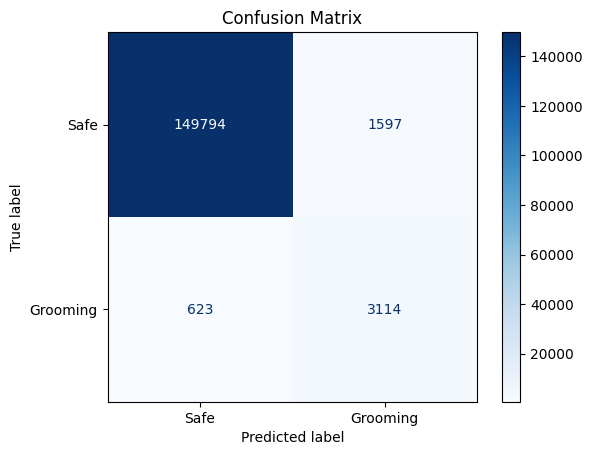

In [ ]:
predictions = trainer.predict(test_data)

preds = np.argmax(predictions.predictions, axis=1)
labels = predictions.label_ids


cm = confusion_matrix(labels, preds)


disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Safe", "Grooming"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

#### **Results**

The model achieved an **accuracy of 98.6%**, indicating that it correctly classified most chat sessions overall. However, accuracy alone is not sufficient for this task due to the likely **class imbalance** (i.e., far more "safe" conversations than grooming ones).

The **F1-score** of **0.737** reflects a solid balance between precision and recall, but shows there's still room for improvement. Specifically:
- **Precision** = 0.661 → Out of all chats predicted as grooming, only ~66% were actually grooming. This means the model has a relatively high **false positive rate**.
- **Recall** = 0.833 → About 83% of actual grooming cases were correctly detected, which is encouraging. The model is good at **catching grooming chats**, though some are still missed.

The **low evaluation loss** (0.098) suggests that the model has learned meaningful patterns, but its lower precision hints that it still **struggles to distinguish risky language from benign conversations**, possibly due to overlapping or ambiguous dialogue.

---

#### Why the Model May Not Be Performing Perfectly

1. **Class Imbalance**: Even with oversampling, grooming examples are fewer and more nuanced. The model may still lean toward the dominant "safe" class.
2. **Subtle Language**: Grooming behavior is context-heavy and often masked behind friendly language, making it harder for the model to learn clear-cut signals.
3. **Limited Context Length**: The model uses only the first 512 tokens. If grooming cues are later in the conversation, they may be truncated.
4. **False Positives**: The model may flag innocent conversations with unusual phrasing or emotive tone as grooming, especially if oversampling overexposed it to aggressive/grooming patterns.

---

#### How to Improve the Model Further

- **Long-context handling**: Use a chunking + aggregation approach during inference to evaluate full conversations beyond 512 tokens.
- **Data augmentation**: Introduce paraphrased or GPT-generated grooming examples to diversify the minority class.
- **Model ensembling**: Combine outputs of multiple lightweight models to increase robustness or use a model with more number of input tokens.

---


